# Модуль 9. **Підбір гіперпараметрів НМ**

In [729]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import keras

from keras.layers import Dense, Dropout
from keras.models import Sequential

from keras import optimizers
from keras import losses
from keras import metrics
import copy

In [730]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:

* кількість шарів;
* кількість нейронів;
* функції активації;
* кількість епох;
* розмір батчу;
* вибір оптимізатора;
* різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

    Завантаження та аналіз даних

In [731]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [732]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [733]:
# from https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#labels
labels_description = {
    "Label": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Description": [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ],
}
labels = pd.DataFrame(labels_description)

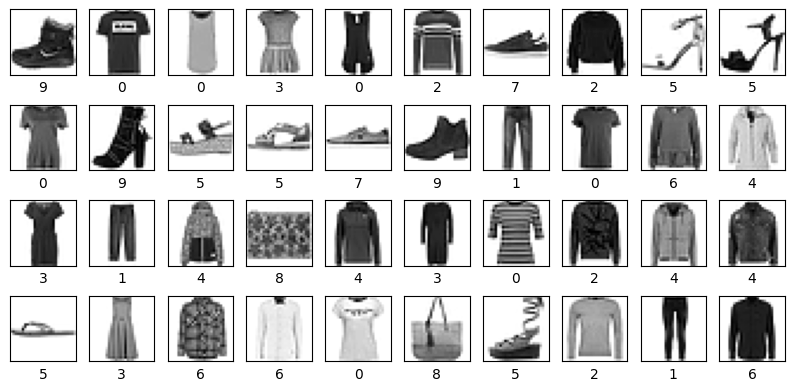

 Label Description
     0 T-shirt/top
     1     Trouser
     2    Pullover
     3       Dress
     4        Coat
     5      Sandal
     6       Shirt
     7     Sneaker
     8         Bag
     9  Ankle boot


In [734]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show() 

print(labels.to_string(index=False))

### Допоміжні функції

    Функція друку поточних параметрів
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [735]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [736]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

    Функція підготовки моделі
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [737]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

    Функція тренування моделі
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [738]:
def train_model(
    train_images,
    train_labels,
    test_images,
    test_labels,
    model_func,
    epochs=10,
    batch_size=32,
    dropout_rate=0.2,
    loss_function="sparse_categorical_crossentropy",
    optimizer="adam",
    hidden_units=128,
    activation="relu",
    metrics=["accuracy"],
    verbose=0,
    summary=0,
):

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return history, test_acc

      Функція пошуку оптимальних параметрів

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [739]:
def find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_func,
    verbose=0,
):

    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:

        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                train_images,
                train_labels,
                test_images,
                test_labels,
                model_func,
                verbose=verbose,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

    Параметри для тренування моделей

In [740]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 64,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 128,
    "activation": "relu",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    # "epochs": [10, 20, 50],
    "epochs": [10, 20, 50, 100],

    # "batch_size": [64, 128],
    "batch_size": [32, 64, 128, 256],

    # "dropout_rate": [0.1, 0.2],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3],

    "loss_function": [
        "sparse_categorical_crossentropy",
        # "binary_crossentropy",
        # "mean_squared_error",
    ],

    # "optimizer": ["adam", "rmsprop"],
    "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],

    "hidden_units": [32, 64, 128, 256],

    # "activation": ["relu", "sigmoid"],
    "activation": ["relu", "sigmoid", "tanh"],

    "metrics": [
        "accuracy",
    ],
}

***
### **Модель для тренування 1** 
***
     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

In [741]:
# Видає помилку: 
# UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. 
# When using Sequential models, prefer using an `Input(shape)` object 
# as the first layer in the model instead.

# def model_1(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28), name="Input"),
#             layers.Dense(hidden_units, activation=activation, name="Hidden_layer"),
#             layers.Dropout(dropout_rate, name="Dropout_layer"),
#             layers.Dense(10, activation="softmax", name="Output"),
#         ]
#     )

In [742]:
# такий варіант помилки не видає, працює так само
# TODO розібратися
def model_1(hidden_units, activation, dropout_rate):
    # # Визначте вхідний шар
    inputs = Input(shape=(28, 28), name="Input")

    # # Додайте шари до моделі
    x = layers.Flatten(name='Flatten')(inputs)
    x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer")(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer")(x)
    outputs = layers.Dense(10, activation="softmax", name="Output")(x)

    # # Створіть модель
    model = Model(inputs, outputs)
    return model

    Параметри, для навчання моделі 1
###### study_sequence - Послідовність дослідження

In [743]:
study_sequence = [
    "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    "optimizer",
    "activation",
    # "metrics",
    "epochs",
]

    Пошук оптимальних параметрів для вказаної моделі 
###### model_1 - функція що досліджується

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.9111 - loss: 0.2364
          тренувальні дані:   0.9110666513442993 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.8783 - loss: 0.3328
          тестові дані:       0.8779000043869019 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


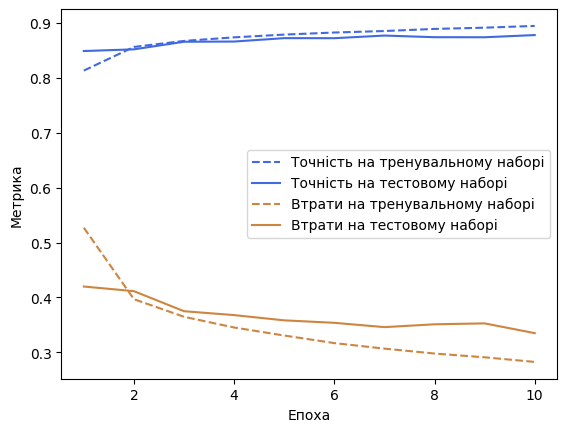

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step - accuracy: 0.9021 - loss: 0.2584
          тренувальні дані:   0.9008333086967468 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.8743 - loss: 0.3564
          тестові дані:       0.8747000098228455 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


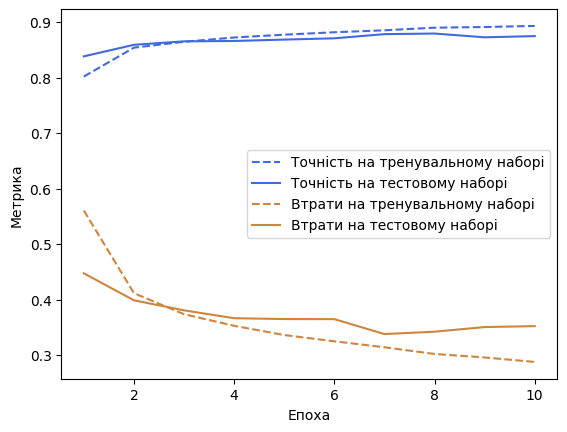

--------------------------------------------------
Тестується значення: batch_size = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - accuracy: 0.9081 - loss: 0.2503
          тренувальні дані:   0.9073500037193298 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.8839 - loss: 0.3289
          тестові дані:       0.8817999958992004 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


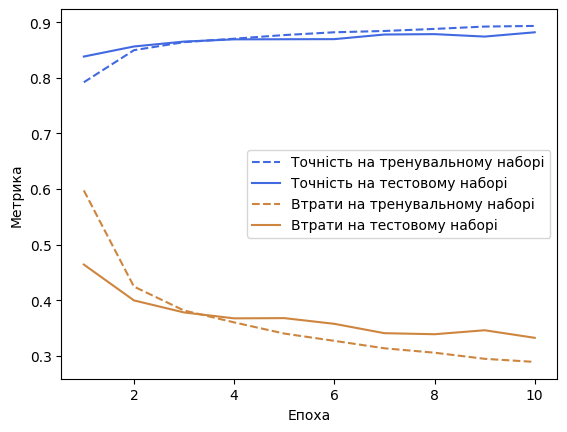

--------------------------------------------------
Тестується значення: batch_size = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step - accuracy: 0.8973 - loss: 0.2782
          тренувальні дані:   0.8972499966621399 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.8726 - loss: 0.3416
          тестові дані:       0.8733000159263611 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 256
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


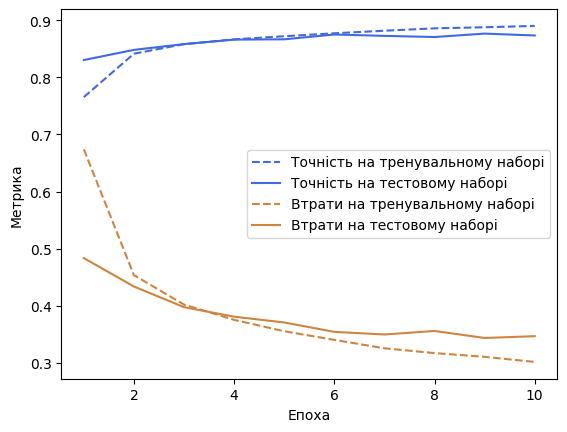

 Оптимальне значення параметра batch_size = 128
   точність на тестових даних: 0.8817999958992004

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 876us/step - accuracy: 0.9078 - loss: 0.2512
          тренувальні дані:   0.9069833159446716 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.8781 - loss: 0.3470
          тестові дані:       0.8784000277519226 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


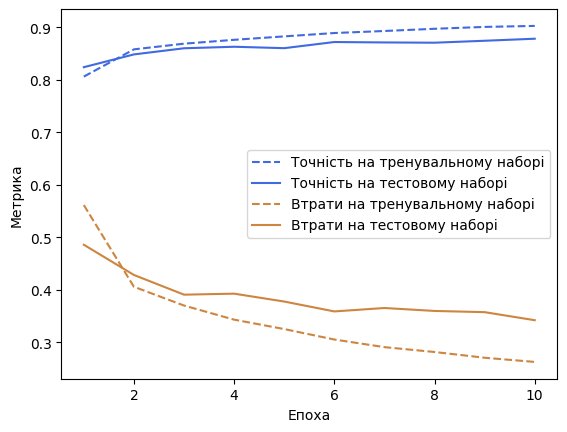

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 872us/step - accuracy: 0.9086 - loss: 0.2482
          тренувальні дані:   0.9075999855995178 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.8803 - loss: 0.3291
          тестові дані:       0.8784999847412109 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


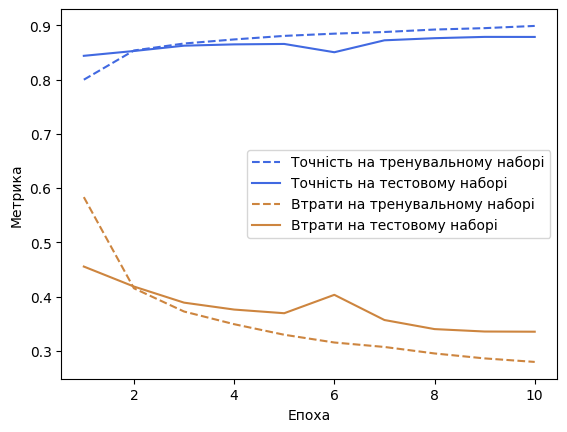

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 872us/step - accuracy: 0.9037 - loss: 0.2584
          тренувальні дані:   0.9034833312034607 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.8804 - loss: 0.3339
          тестові дані:       0.8795999884605408 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


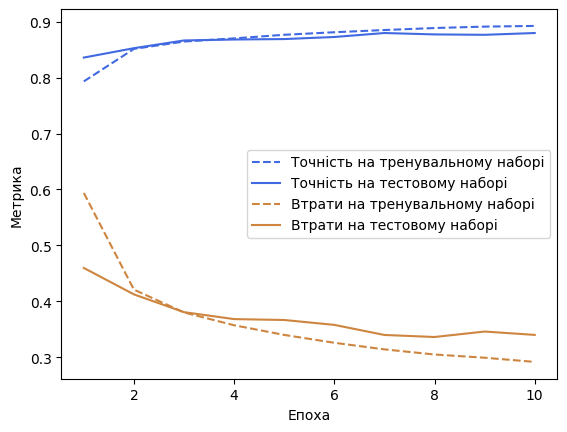

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 801us/step - accuracy: 0.9006 - loss: 0.2637
          тренувальні дані:   0.9009333252906799 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8795 - loss: 0.3343
          тестові дані:       0.8787999749183655 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


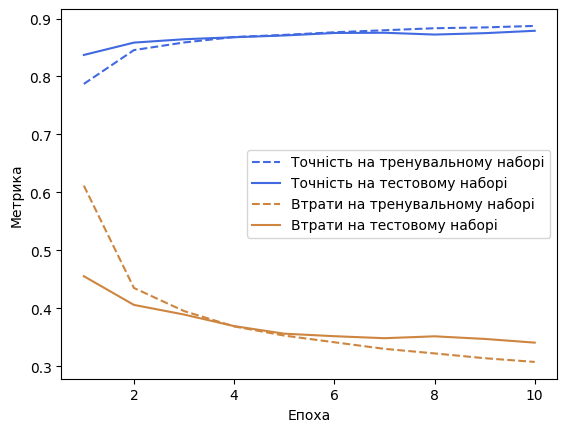

 Оптимальне значення параметра dropout_rate = 0.2
   точність на тестових даних: 0.8817999958992004

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.8818 - loss: 0.3232
          тренувальні дані:   0.8811833262443542 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.8613 - loss: 0.3813
          тестові дані:       0.858299970626831 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']


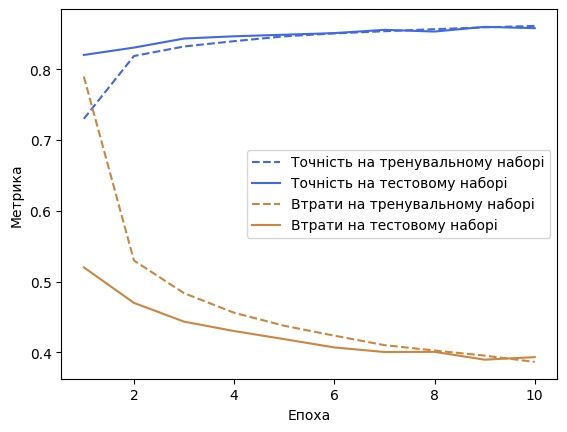

--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.8917 - loss: 0.2900
          тренувальні дані:   0.8924833536148071 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.8756 - loss: 0.3491
          тестові дані:       0.8716999888420105 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


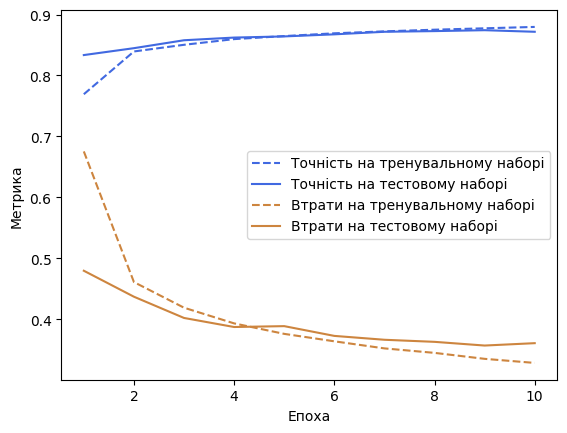

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 845us/step - accuracy: 0.9093 - loss: 0.2443
          тренувальні дані:   0.9099000096321106 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.8841 - loss: 0.3253
          тестові дані:       0.8848000168800354 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


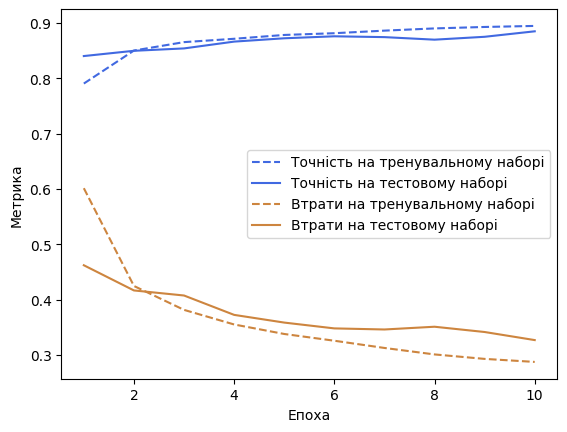

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - accuracy: 0.9101 - loss: 0.2443
          тренувальні дані:   0.90829998254776 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.8827 - loss: 0.3239
          тестові дані:       0.8792999982833862 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


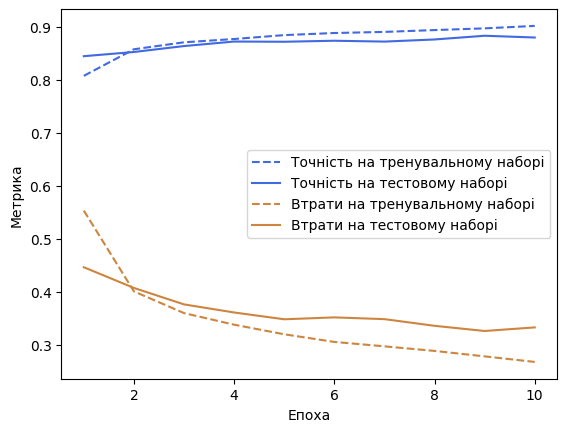

 Оптимальне значення параметра hidden_units = 128
   точність на тестових даних: 0.8848000168800354

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.9083 - loss: 0.2513
          тренувальні дані:   0.9068166613578796 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.8817 - loss: 0.3267
          тестові дані:       0.8794000148773193 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


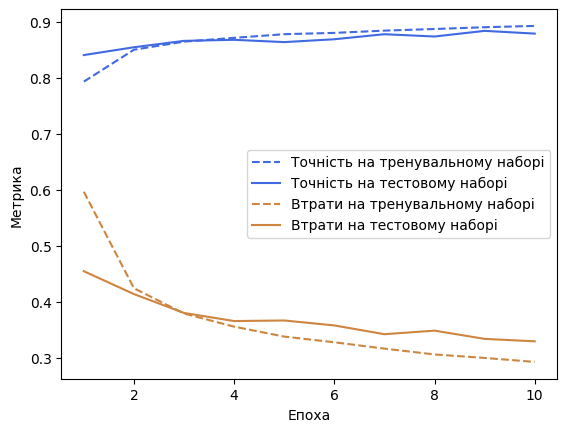

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.8976 - loss: 0.2717
          тренувальні дані:   0.8984333276748657 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.8715 - loss: 0.3595
          тестові дані:       0.8722000122070312 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


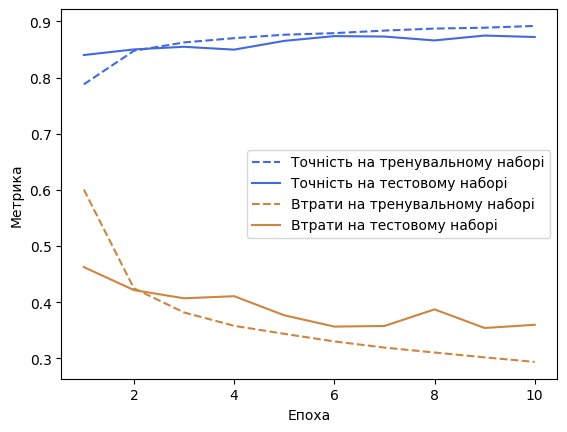

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - accuracy: 0.8428 - loss: 0.4605
          тренувальні дані:   0.8427000045776367 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.8367 - loss: 0.4850
          тестові дані:       0.8299999833106995 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


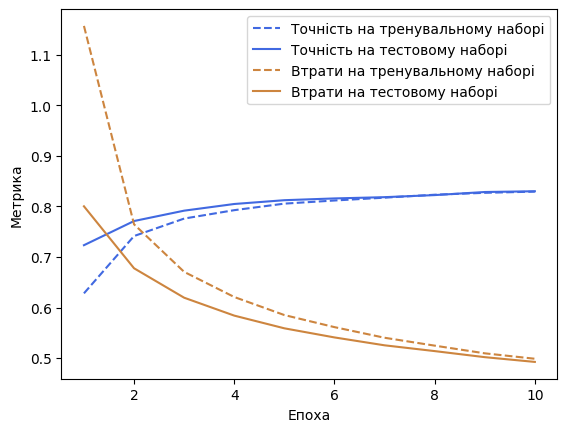

--------------------------------------------------
Тестується значення: optimizer = adagrad
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.7942 - loss: 0.6382
          тренувальні дані:   0.7947499752044678 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.7826 - loss: 0.6537
          тестові дані:       0.7791000008583069 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adagrad
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


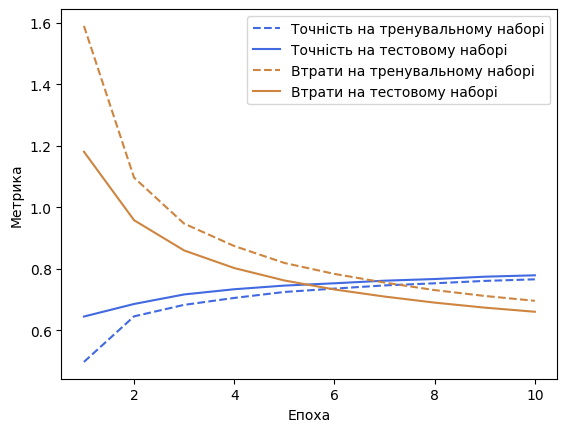

--------------------------------------------------
Тестується значення: optimizer = adadelta
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.6538 - loss: 1.3274
          тренувальні дані:   0.6534500122070312 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6490 - loss: 1.3345
          тестові дані:       0.6473000049591064 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adadelta
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


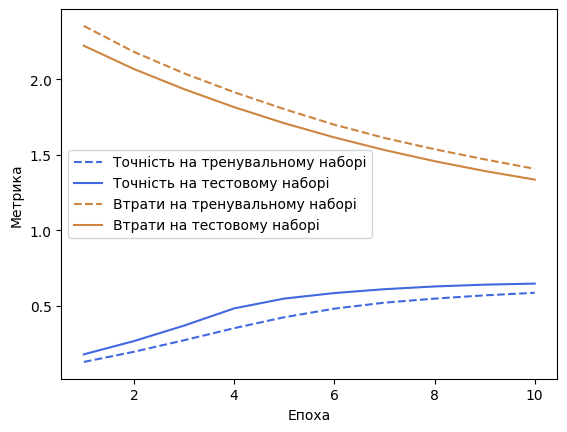

 Оптимальне значення параметра optimizer = adam
   точність на тестових даних: 0.8848000168800354

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.9072 - loss: 0.2505
          тренувальні дані:   0.9066166877746582 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.8822 - loss: 0.3275
          тестові дані:       0.8812999725341797 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


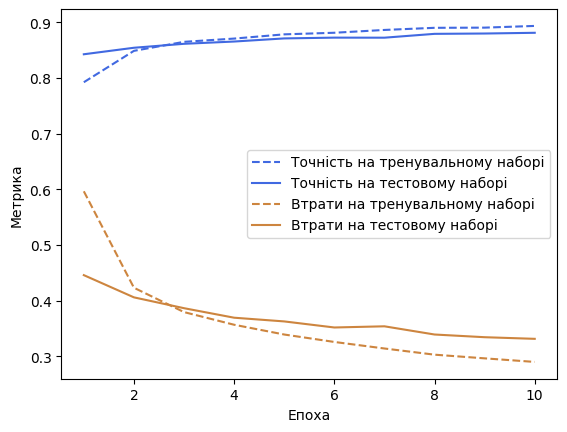

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.8908 - loss: 0.3006
          тренувальні дані:   0.8912333250045776 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.8749 - loss: 0.3536
          тестові дані:       0.8707000017166138 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']


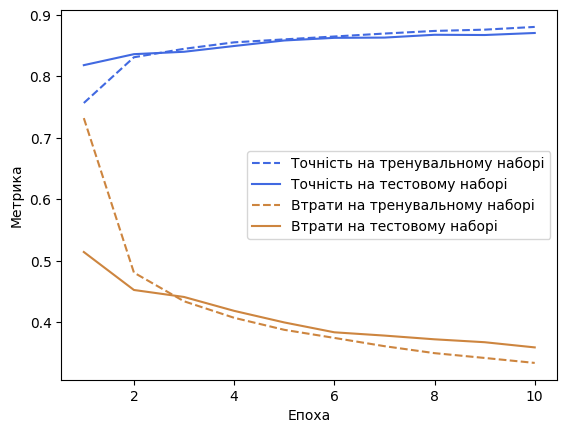

--------------------------------------------------
Тестується значення: activation = tanh
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.8931 - loss: 0.2889
          тренувальні дані:   0.8938666582107544 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.8735 - loss: 0.3580
          тестові дані:       0.8704000115394592 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= tanh
 metrics 	= ['accuracy']


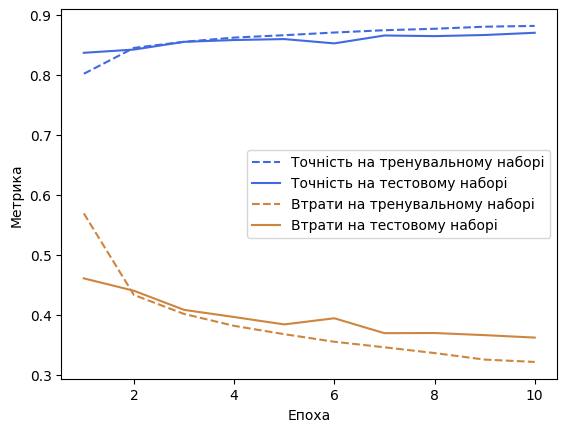

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.8848000168800354

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.9048 - loss: 0.2617
          тренувальні дані:   0.9032666683197021 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.8756 - loss: 0.3441
          тестові дані:       0.876800000667572 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


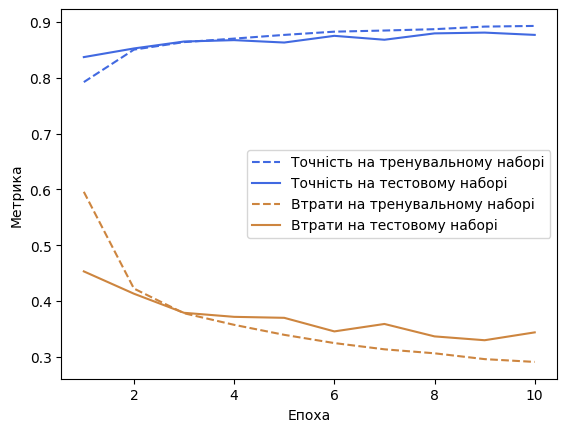

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 855us/step - accuracy: 0.9239 - loss: 0.2024
          тренувальні дані:   0.9235333204269409 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.8884 - loss: 0.3195
          тестові дані:       0.8871999979019165 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


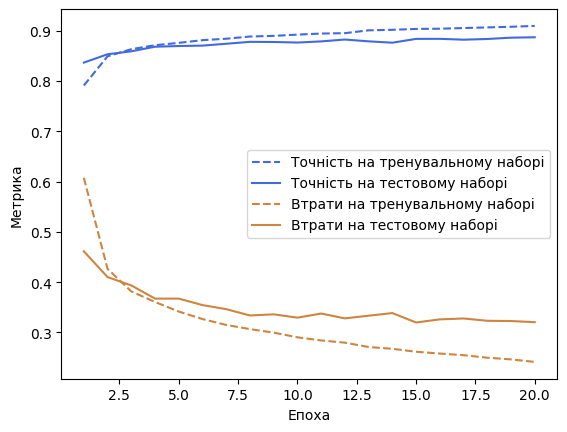

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.9516 - loss: 0.1294
          тренувальні дані:   0.9519666433334351 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.8951 - loss: 0.3443
          тестові дані:       0.8950999975204468 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


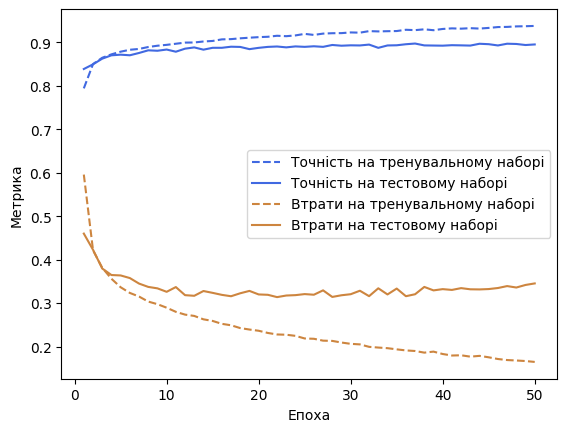

--------------------------------------------------
Тестується значення: epochs = 100
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 845us/step - accuracy: 0.9695 - loss: 0.0799
          тренувальні дані:   0.9699166417121887 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8933 - loss: 0.4215
          тестові дані:       0.890999972820282 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


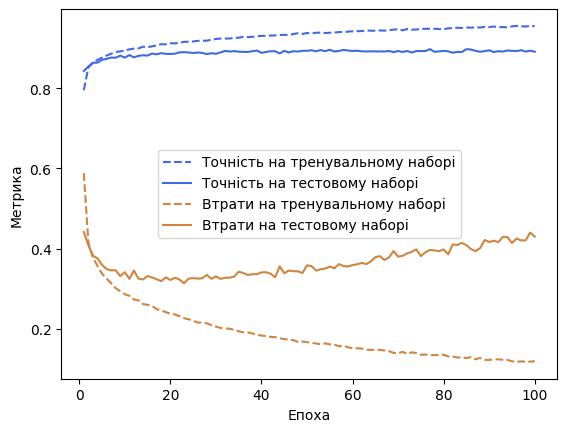

 Оптимальне значення параметра epochs = 50
   точність на тестових даних: 0.8950999975204468



In [744]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_1,
)

In [745]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_1
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.8950999975204468


<div class="alert alert-block alert-info">
<b>Висновки model_1:</b> 
<p>Отримано оптимальні параметри для базової моделі з одним прихованим шаром<br>Навіть за оптимізованих параметрів точність моделі (<b>0.8923</b>) недостатня</p>
</div>

***
### **Модель для тренування 2** 
***
_Ускладнимо модель, додавши два додаткових Dense-шари (3 та 4)_

     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 2 рази менше, ніж у шара 2 та активаційною функцією, які вказані у параметрах.
4. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 4 рази менше, ніж у шара 2 та активаційною функцією, які вказані у параметрах.
5. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

_також скоротимо перелік параметрів, що досліджуються до трьох_
1. 'dropout_rate',
2. 'hidden_units',
3. 'epochs'

In [746]:
# def model_2(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28)),
#             layers.Dense(hidden_units, activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 2), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 4), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(10, activation="softmax"),
#         ]
#     )

In [747]:
# такий варіант помилки не видає, працює так само
# TODO розібратися
def model_2(hidden_units, activation, dropout_rate):
    # # Визначте вхідний шар
    inputs = Input(shape=(28, 28), name="Input")

    # # Додайте шари до моделі
    x = layers.Flatten(name="Flatten")(inputs)
    x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer_1")(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_1")(x)
    x = layers.Dense(
        int(hidden_units / 2), activation=activation, name="Hidden_layer_2"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_2")(x)
    x = layers.Dense(
        int(hidden_units / 4), activation=activation, name="Hidden_layer_3"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_3")(x)
    outputs = layers.Dense(10, activation="softmax", name="Output")(x)

    # # Створіть модель
    model = Model(inputs, outputs)
    return model

In [748]:
study_sequence = [
    # "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - accuracy: 0.9664 - loss: 0.0893
          тренувальні дані:   0.965583324432373 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8908 - loss: 0.4932
          тестові дані:       0.8901000022888184 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


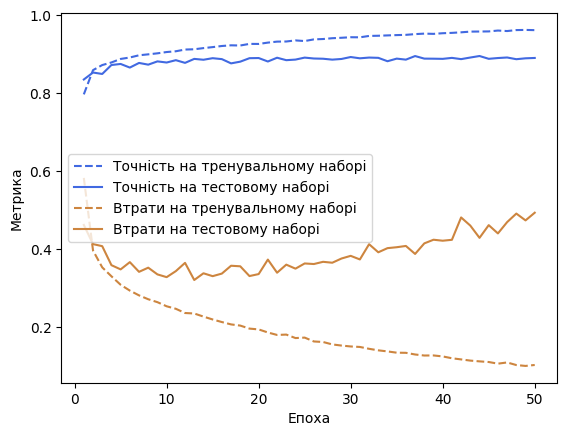

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.9513 - loss: 0.1302
          тренувальні дані:   0.9509333372116089 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8899 - loss: 0.3594
          тестові дані:       0.8896999955177307 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


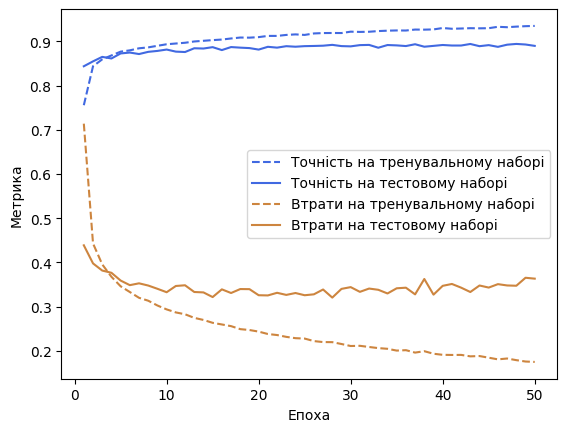

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9361 - loss: 0.1669
          тренувальні дані:   0.936033308506012 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.8937 - loss: 0.3360
          тестові дані:       0.8924999833106995 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


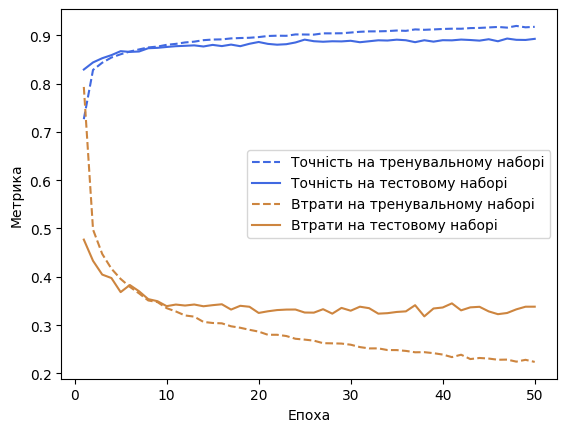

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.9237 - loss: 0.2018
          тренувальні дані:   0.9232000112533569 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.8887 - loss: 0.3378
          тестові дані:       0.8889999985694885 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


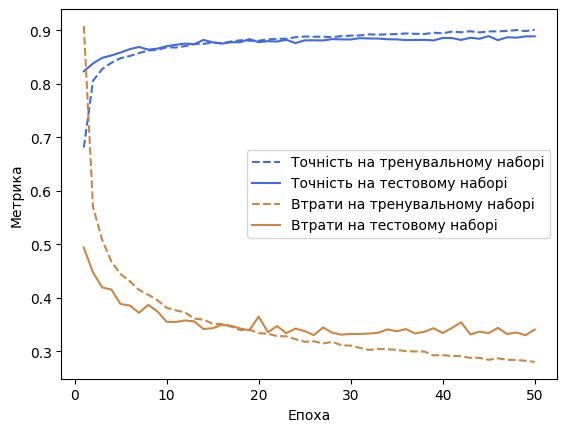

 Оптимальне значення параметра dropout_rate = 0.2
   точність на тестових даних: 0.8924999833106995

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.8786 - loss: 0.3576
          тренувальні дані:   0.8795333504676819 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.8585 - loss: 0.4408
          тестові дані:       0.8554999828338623 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']


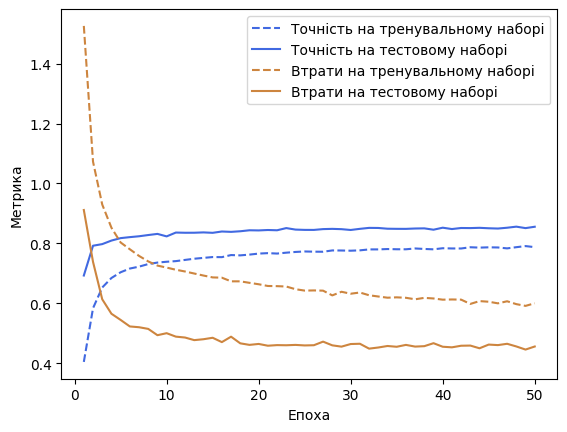

--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 792us/step - accuracy: 0.9132 - loss: 0.2288
          тренувальні дані:   0.9134500026702881 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.8802 - loss: 0.3584
          тестові дані:       0.8765000104904175 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


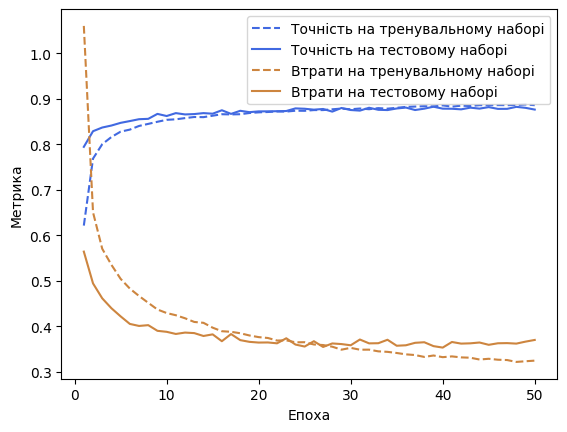

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 896us/step - accuracy: 0.9371 - loss: 0.1651
          тренувальні дані:   0.9366666674613953 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.8886 - loss: 0.3462
          тестові дані:       0.8899000287055969 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


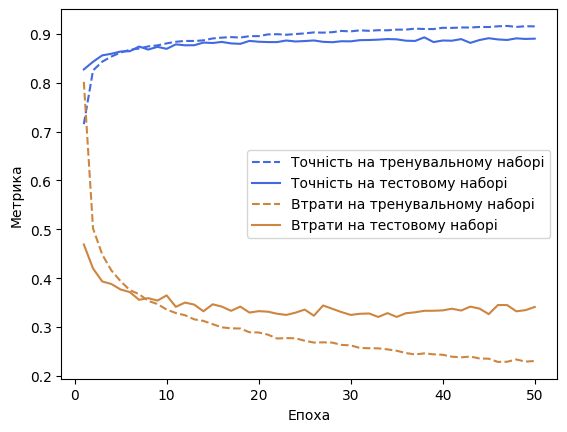

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9488 - loss: 0.1348
          тренувальні дані:   0.9481333494186401 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8952 - loss: 0.3546
          тестові дані:       0.8937000036239624 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


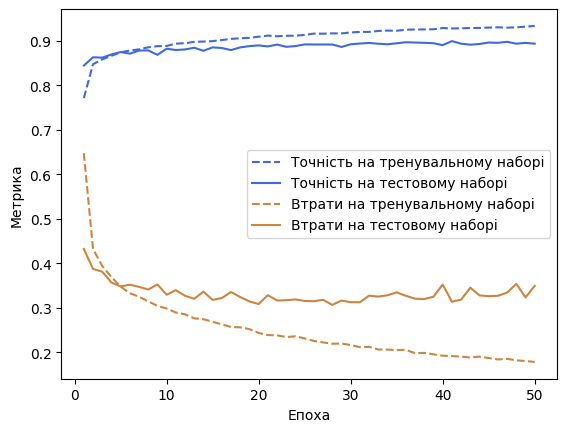

 Оптимальне значення параметра hidden_units = 256
   точність на тестових даних: 0.8937000036239624

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 948us/step - accuracy: 0.9085 - loss: 0.2387
          тренувальні дані:   0.9089999794960022 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8825 - loss: 0.3258
          тестові дані:       0.8822000026702881 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


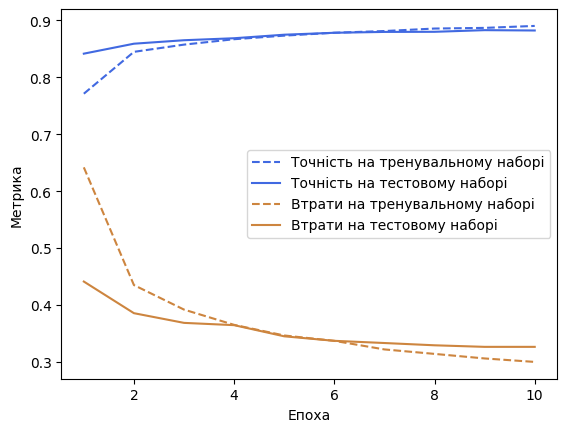

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - accuracy: 0.9216 - loss: 0.2023
          тренувальні дані:   0.9221500158309937 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.8847 - loss: 0.3269
          тестові дані:       0.8859999775886536 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


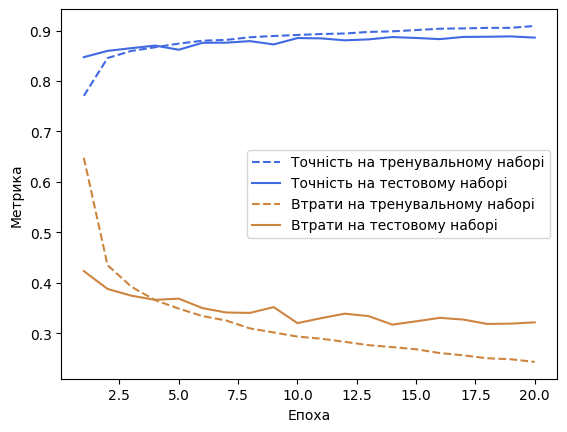

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9522 - loss: 0.1304
          тренувальні дані:   0.951116681098938 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.8962 - loss: 0.3492
          тестові дані:       0.8977000117301941 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


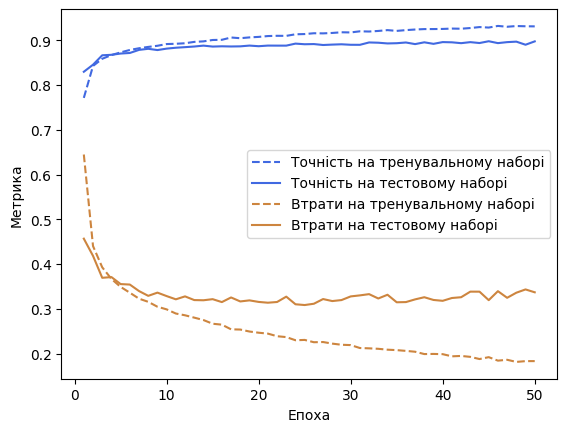

--------------------------------------------------
Тестується значення: epochs = 100
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1000us/step - accuracy: 0.9701 - loss: 0.0804
          тренувальні дані:   0.9699166417121887 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.8971 - loss: 0.3959
          тестові дані:       0.8981000185012817 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


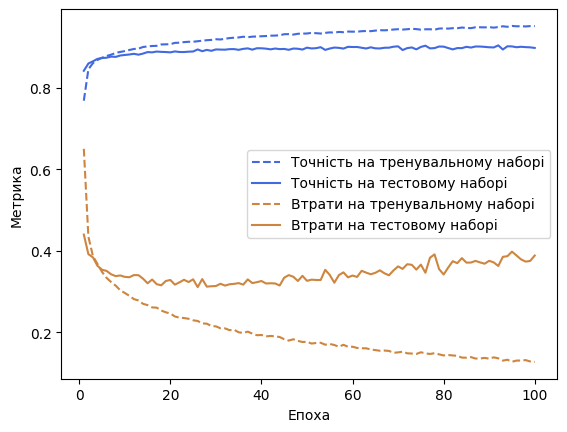

 Оптимальне значення параметра epochs = 100
   точність на тестових даних: 0.8981000185012817



In [749]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_2,
)

In [750]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_2
 epochs 	= 100
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.8981000185012817


<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі з трьома прихованими шарами<br>Спостерігається <b>невеличке покращення</b> роботи моделі після її ускладнення<br>
<b>Точність</b> на тестових даних змінилася з <b>0.8923</b> до <b>0.8974</b>, при цьому втрати на тестових даних сягають 0.3916</p>
<p>Оптимальні параметри змінилися тільки в двох пунктах: <br>
1. dropout_rate було 0.2 стало 0.1<br>
2. hidden_units було 128 стало 256</p>
</div>

***
### **Модель для тренування 2.1** 
***

_додамо ще 2 hidden layers_ <br>
тестуємо     "optimizer", "dropout_rate", "hidden_units", "activation",

In [763]:
# def model_3(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28)),
#             layers.Dense(hidden_units, activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 2), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 4), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 2), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 1), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(10, activation="softmax"),
#         ]
#     )

In [764]:
# такий варіант помилки не видає, працює так само
# TODO розібратися
def model_2_1(hidden_units, activation, dropout_rate):
    # # Визначте вхідний шар
    inputs = Input(shape=(28, 28), name="Input")

    # # Додайте шари до моделі
    x = layers.Flatten(name="Flatten")(inputs)
    x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer_1")(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_1")(x)
    x = layers.Dense(
        int(hidden_units / 2), activation=activation, name="Hidden_layer_2"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_2")(x)
    x = layers.Dense(
        int(hidden_units / 4), activation=activation, name="Hidden_layer_3"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_3")(x)
    outputs = layers.Dense(10, activation="softmax", name="Output")(x)

    # # Створіть модель
    model = Model(inputs, outputs)
    return model

In [765]:
# model = models.Sequential(
#     [
#         layers.Flatten(input_shape=(28, 28)),
#         layers.Dense(512, activation="relu"),
#         layers.Dropout(0.2),
#         layers.Dense(256, activation="relu"),
#         layers.Dropout(0.2),
#         layers.Dense(128, activation="relu"),
#         layers.Dropout(0.2),
#         layers.Dense(10, activation="softmax"),
#     ]
# )

# model.compile(
#     optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

# history = model.fit(
#     train_x, train_y, epochs=20, batch_size=512, validation_split=0.2, verbose=1
# )

In [766]:
study_sequence = [
    "batch_size",
    # "optimizer",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    "activation",
    # "metrics",
    "epochs",
]

In [767]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 128,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 128,
    "activation": "relu",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "epochs": [10, 20, 50],
    # "epochs": [10, 20, 50, 100],
    
    "batch_size": [128, 256, 512],
    # "batch_size": [32, 64, 128, 256],
    
    "dropout_rate": [0.1, 0.2],
    # "dropout_rate": [0.0, 0.1, 0.2, 0.3],
    "loss_function": [
        "sparse_categorical_crossentropy",
        # "binary_crossentropy",
        # "mean_squared_error",
    ],
    "optimizer": ["adam", "rmsprop"],
    # "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],
    
    "hidden_units": [128, 256, 512],
    # "hidden_units": [32, 64, 128, 256],
    
    "activation": ["relu", "sigmoid"],
    # "activation": ["relu", "sigmoid", "tanh"],
    
    "metrics": [
        "accuracy",
    ],
}

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step - accuracy: 0.9082 - loss: 0.2394
          тренувальні дані:   0.9078333377838135 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8840 - loss: 0.3332
          тестові дані:       0.8813999891281128 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


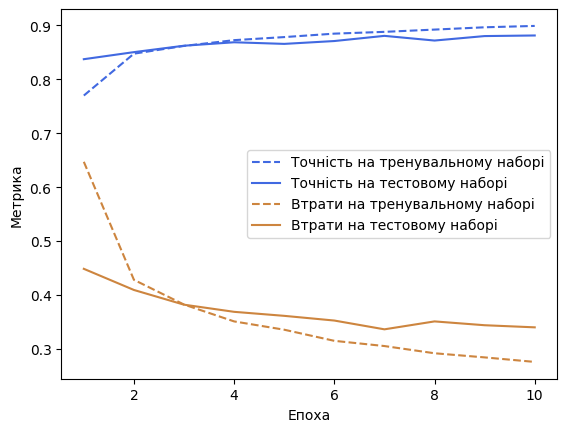

--------------------------------------------------
Тестується значення: batch_size = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step - accuracy: 0.9034 - loss: 0.2549
          тренувальні дані:   0.9029499888420105 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.8790 - loss: 0.3414
          тестові дані:       0.8783000111579895 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 256
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


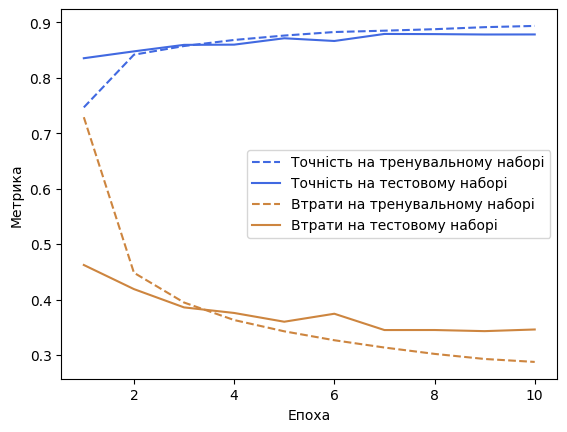

--------------------------------------------------
Тестується значення: batch_size = 512
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step - accuracy: 0.8998 - loss: 0.2677
          тренувальні дані:   0.8980833292007446 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8744 - loss: 0.3440
          тестові дані:       0.8730999827384949 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 512
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


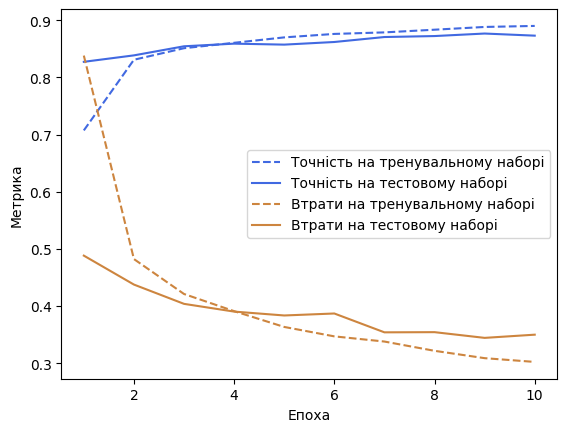

 Оптимальне значення параметра batch_size = 128
   точність на тестових даних: 0.8813999891281128

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 943us/step - accuracy: 0.9134 - loss: 0.2301
          тренувальні дані:   0.9132000207901001 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8841 - loss: 0.3388
          тестові дані:       0.8827999830245972 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


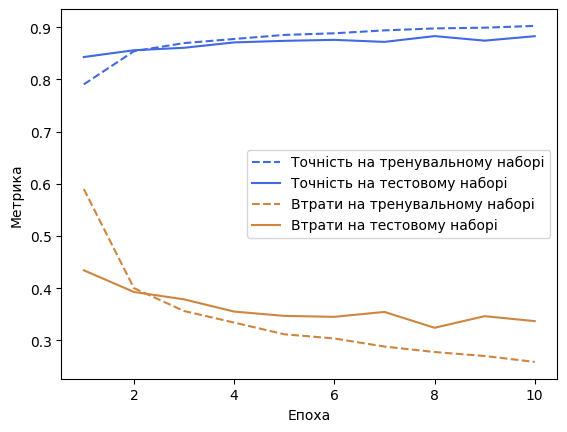

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 891us/step - accuracy: 0.9119 - loss: 0.2351
          тренувальні дані:   0.9106500148773193 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.8801 - loss: 0.3371
          тестові дані:       0.8851000070571899 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


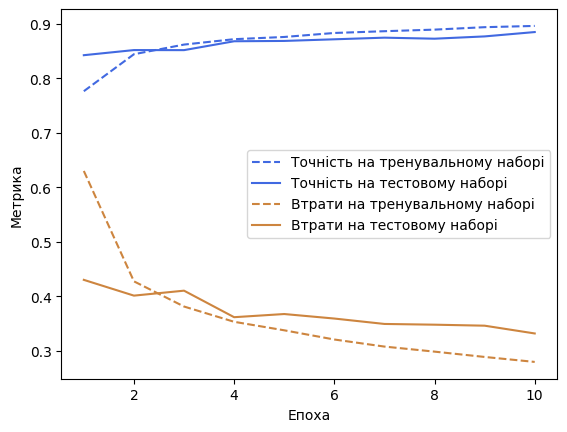

 Оптимальне значення параметра dropout_rate = 0.2
   точність на тестових даних: 0.8851000070571899

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 937us/step - accuracy: 0.9127 - loss: 0.2307
          тренувальні дані:   0.9116666913032532 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8819 - loss: 0.3320
          тестові дані:       0.8819000124931335 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


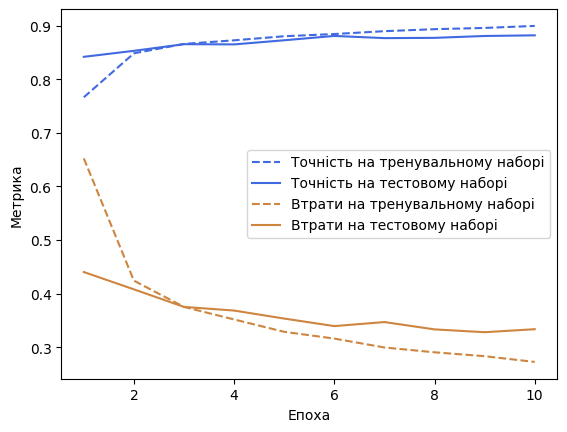

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9171 - loss: 0.2182
          тренувальні дані:   0.916183352470398 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8841 - loss: 0.3210
          тестові дані:       0.8851000070571899 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


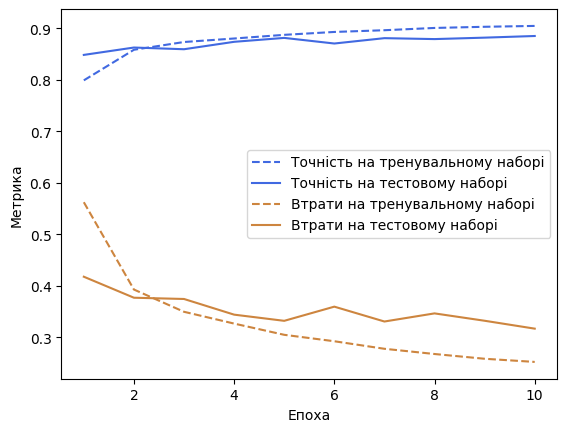

--------------------------------------------------
Тестується значення: hidden_units = 512
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9201 - loss: 0.2151
          тренувальні дані:   0.9194666743278503 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8805 - loss: 0.3316
          тестові дані:       0.8828999996185303 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


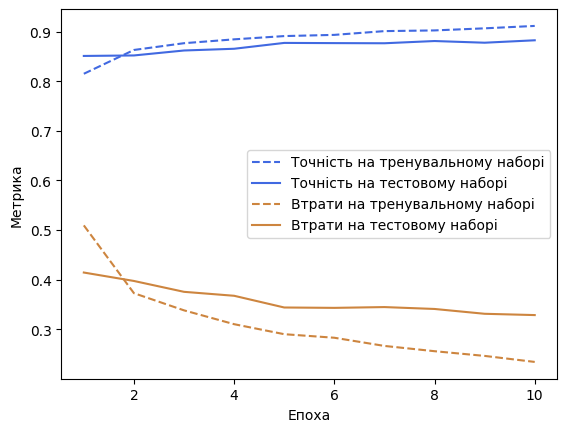

 Оптимальне значення параметра hidden_units = 128
   точність на тестових даних: 0.8851000070571899

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - accuracy: 0.9098 - loss: 0.2401
          тренувальні дані:   0.9089166522026062 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.8814 - loss: 0.3276
          тестові дані:       0.8810999989509583 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


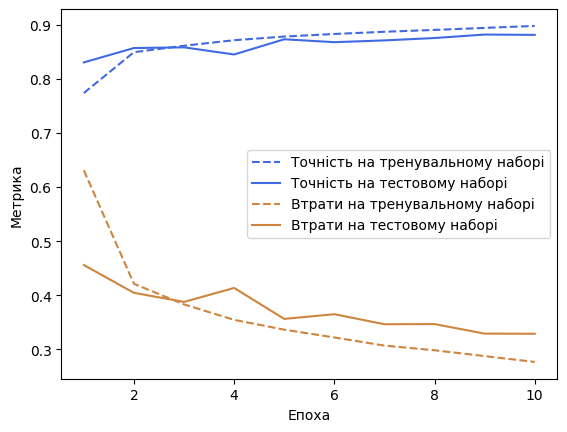

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 906us/step - accuracy: 0.8969 - loss: 0.2800
          тренувальні дані:   0.8970999717712402 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.8767 - loss: 0.3447
          тестові дані:       0.8741999864578247 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']


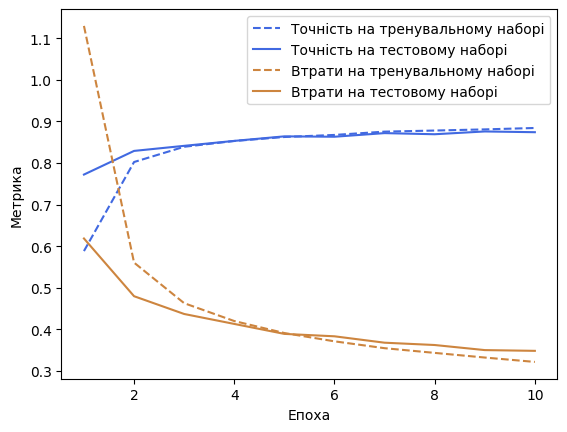

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.8851000070571899

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 883us/step - accuracy: 0.9032 - loss: 0.2556
          тренувальні дані:   0.9028833508491516 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.8767 - loss: 0.3522
          тестові дані:       0.8761000037193298 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


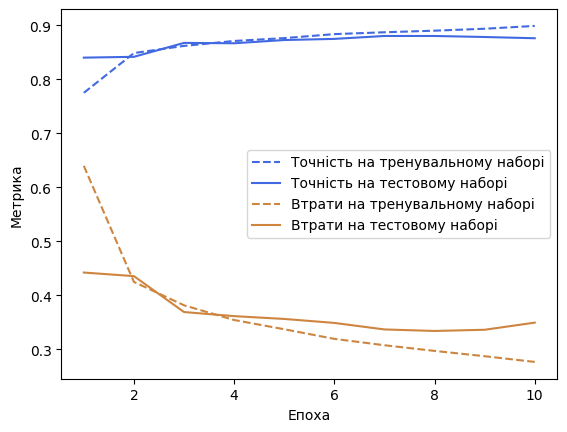

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - accuracy: 0.9207 - loss: 0.2040
          тренувальні дані:   0.9208833575248718 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.8855 - loss: 0.3586
          тестові дані:       0.8866999745368958 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


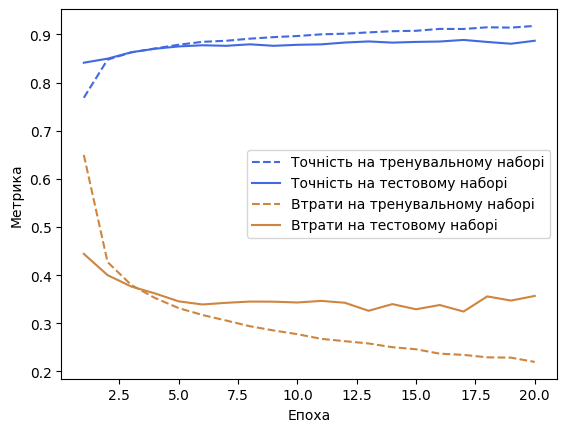

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step - accuracy: 0.9513 - loss: 0.1220
          тренувальні дані:   0.9506166577339172 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.8848 - loss: 0.4602
          тестові дані:       0.8862000107765198 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


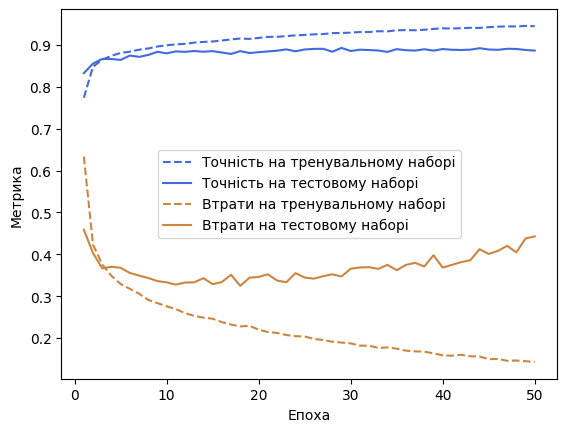

 Оптимальне значення параметра epochs = 20
   точність на тестових даних: 0.8866999745368958



In [768]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_2_1,
)

In [769]:
print_parameters(best_parameters, "Оптимальні параметри для model_3")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_3
 epochs 	= 20
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.8866999745368958


<div class="alert alert-block alert-info">
<b>Висновки model_3:</b> 
<p>Отримано оптимальні параметри для більш ускладненої моделі зі згортковими шарами<br>Вдалося досягнути максимального значення точності 0,919, але втрати на тестових даних становлять 0.6472<br>До того ж, оптимальні параметри залишились такими самими, як для model_2</p>
</div>